In [1]:
%load_ext autoreload
%autoreload 2
import uproot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
from model import LitS4Model
from data import LitDataModule
from plotting import *
import torch
from torch.utils.data import DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import tqdm
from scipy.fft import fft, fftfreq
import glob
import os
import json

In [2]:
CHECKPOINT = '/home/lfd34/project/project8/ssm/neutrino_project/runs/input_I__output_energy_pitch__d_model_10_n_layers_6_gamma0.75_normX/lightning_logs/8lh4zd0e/checkpoints/last.ckpt'

In [3]:
model = LitS4Model.load_from_checkpoint(CHECKPOINT)
model = model.to(device)
model = model.eval()

/home/lfd34/.conda/envs/ssm/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.


In [4]:
#dataset = LitDataModule.load_from_checkpoint(CHECKPOINT, inputs=['output_ts_I'], variables=model.variables)
dataset = LitDataModule.load_from_checkpoint(CHECKPOINT)

In [5]:
true = []
pred = []
meta = []
timeseries = []

for ts,var,obs in dataset.test_dataloader():
    with torch.no_grad():
        timeseries.append(ts.cpu().numpy())
        pred.append(model(ts.to(device)).cpu().numpy())
        true.append(var.numpy())
        meta.append(obs.numpy())

/home/lfd34/.conda/envs/ssm/lib/python3.10/site-packages/torch/nn/functional.py:1381: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


In [6]:
# undo the normalization
pred_post = pred * dataset.stds + dataset.mu
true_post = true * dataset.stds + dataset.mu

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (796,) + inhomogeneous part.

In [7]:
true = np.concatenate(true, axis=0)
pred = np.concatenate(pred, axis=0)
meta = np.concatenate(meta, axis=0)

In [8]:
timeseries = np.concatenate(timeseries, axis = 0).squeeze(-1)

In [9]:
def fft_and_freq(signal, T, w=1):
    N = len(signal)
    yf = fft(signal*w)
    xf = fftfreq(N, T)[:N//2]
    return xf[1:N//2], 2.0/N * np.abs(yf[1:N//2])

In [50]:
event = 190
sampling_freq = 403.0e6 #Hz
lo_freq = 2.59702e+10
timestep = 1/sampling_freq

freq, amplitudes = fft_and_freq(timeseries[event], timestep/2)
truth_freqs = meta[:,1] + sampling_freq/2 - lo_freq

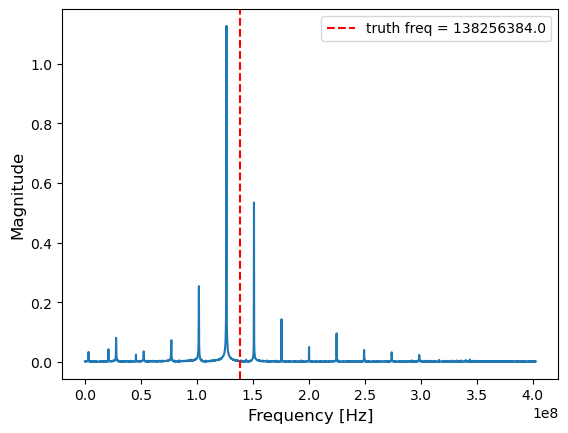

In [51]:
plt.plot(freq, amplitudes)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.axvline(x=truth_freqs[event], color='red', linestyle='--', label=f"truth freq = {truth_freqs[event]}")
plt.legend(loc="upper right")
plt.show()

In [22]:
fft_freq_peaks = np.zeros(timeseries.shape[0])

for i in range(timeseries.shape[0]):
    freq, amplitudes = fft_and_freq(timeseries[i], timestep)
    fft_freq_peaks[i] = freq[np.argmax(amplitudes)]

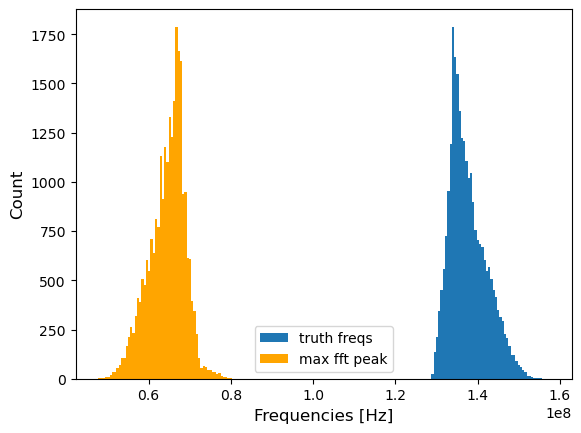

In [24]:
freq_bins = np.linspace(np.min(fft_freq_peaks), np.max(truth_freqs), 200)
plt.hist(truth_freqs, bins=freq_bins, label="truth freqs")
plt.hist(fft_freq_peaks, bins=freq_bins, color = "orange", label="max fft peak")
plt.legend()
plt.xlabel("Frequencies [Hz]")
plt.ylabel("Count")
plt.show()

In [34]:
truthPath = '/gpfs/gibbs/pi/heeger/spreadsheetData/SpreadsheetRow38_SSM_reGenerated/'
intermediatePath = 'Trap_CCA_long_trap_44_TE011_onRes_EVev_FieldMap_5_7apLength_QL400_coarse_CombinedSet/results/'

truth_start_freqs_row38 = []

search_pattern = os.path.join(truthPath, '*', intermediatePath, '*/LocustEventProperties.json')

json_files = glob.glob(search_pattern)

print(f"Found {len(json_files)} JSON files to process.")

for truthfile_path in json_files:
    with open(truthfile_path) as json_file:
        file_data = json.load(json_file)
        for ievent in range(file_data["nevents"]):
            if file_data[str(ievent)]["ntracks"]!=1:
                print(str(file_data[str(ievent)]["ntracks"]) + ' tracks in event! Check that dataset used is correct for this analysis!')
                break
            else:
                for itrack in range(file_data[str(ievent)]["ntracks"]):
                    truth_start_freqs_row38.append(file_data[str(ievent)][str(itrack)]["output-track-start-frequency"])

truth_start_freqs_row38 = np.array(truth_start_freqs_row38)

Found 101308 JSON files to process.


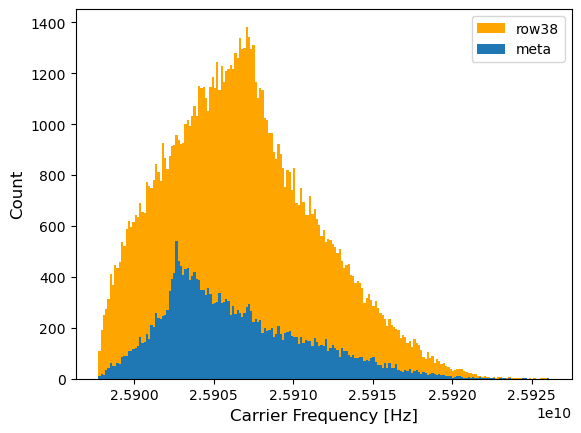

In [35]:
upconverted_row38_freqs = truth_start_freqs_row38 - sampling_freq/2 + lo_freq
freq_bins = np.linspace(np.min(truth_freqs), np.max(truth_freqs), 200)
plt.hist(upconverted_row38_freqs, bins=freq_bins, color = "orange", label="row38")
plt.hist(truth_freqs, bins=freq_bins, label="meta")
plt.legend()
plt.xlabel("Carrier Frequency [Hz]")
plt.ylabel("Count")
plt.show()

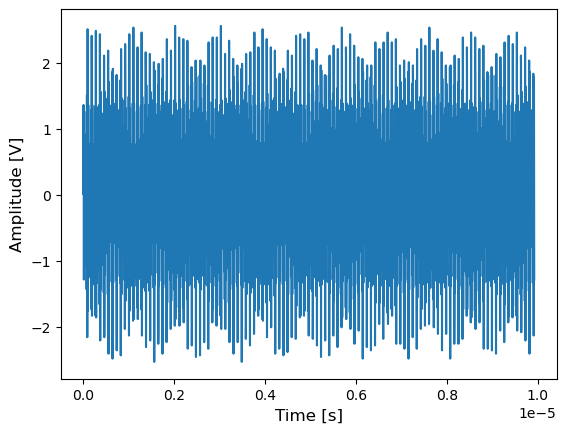

In [39]:
time = np.arange(0, 9.92555831e-6,timestep)
plt.plot(time, timeseries[20])
plt.xlabel("Time [s]")
plt.ylabel("Amplitude [V]")
plt.show()